In [1]:
import mlrun
import pandas as pd
import requests

# Explore

In [6]:
PROJECT = "demobo"

In [132]:
project = mlrun.get_or_create_project("demobo", "./")

> 2023-05-05 15:54:05,830 [info] loaded project demobo from ./ and saved in MLRun DB


In [131]:
project = mlrun.new_project("demobo", "./", user_project=True, init_git=True, description="demo bologna")

TypeError: get_or_create_project() got an unexpected keyword argument 'description'

In [133]:
print(project)

{'kind': 'project', 'metadata': {'name': 'demobo'}, 'spec': {'description': 'demo bologna', 'functions': [{'url': 'download-data.py', 'name': 'download-data', 'kind': 'job', 'image': 'mlrun/mlrun', 'handler': 'downloader'}], 'workflows': [], 'artifacts': [], 'source': '', 'desired_state': 'online'}}


In [11]:
URL = "https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/rilevazione-flusso-veicoli-tramite-spire-anno-2023/exports/csv?lang=it&timezone=Europe%2FRome&use_labels=true&delimiter=%3B"
filename = "rilevazione-flusso-veicoli-tramite-spire-anno-2023.csv"

In [12]:
with requests.get(URL) as r:
    with open(filename, "wb") as f:
        f.write(r.content)


In [15]:
df = pd.read_csv(filename, sep=";")

In [16]:
df.head()

,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,Nodo a,ordinanza,stato,codimpsem,direzione,angolo,longitudine,latitudine,geopoint,giorno settimana
0,2023-01-01,0.127 1.4 2 1,111,114,100,51,42,24,23,26,...,15170,4000/343434,A,318,S,170.0,11.347424,44.500815,"44.5008152038968, 11.3474244254298",Domenica
1,2023-01-01,0.127 1.5 8 1,53,67,50,41,36,48,28,41,...,10242,4000/343434,A,250,E,255.0,11.343170,44.501419,"44.501419288531, 11.3431701717514",Domenica
2,2023-01-01,0.127 1.12 8 1,68,63,47,31,12,14,19,8,...,84,4000/343434,A,316,N,350.0,11.338970,44.495251,"44.4952505129043, 11.338970003537",Domenica
3,2023-01-01,0.127 1.15 6 1,58,99,61,50,25,25,32,16,...,6053,4000/343434,A,324,S,168.0,11.343443,44.490027,"44.4900271601578, 11.3434427397635",Domenica
4,2023-01-01,0.127 1.17 4 1,31,57,55,27,20,15,11,11,...,6137,4000/343434,A,325,NE,333.0,11.350903,44.492369,"44.4923692879684, 11.3509026754331",Domenica


In [17]:
df.dtypes

data                 object
codice spira         object
00:00-01:00           int64
01:00-02:00           int64
02:00-03:00           int64
03:00-04:00           int64
04:00-05:00           int64
05:00-06:00           int64
06:00-07:00           int64
07:00-08:00           int64
08:00-09:00           int64
09:00-10:00           int64
10:00-11:00           int64
11:00-12:00           int64
12:00-13:00           int64
13:00-14:00           int64
14:00-15:00           int64
15:00-16:00           int64
16:00-17:00           int64
17:00-18:00           int64
18:00-19:00           int64
19:00-20:00           int64
20:00-21:00           int64
21:00-22:00           int64
22:00-23:00           int64
23:00-24:00           int64
id_uni                int64
Livello               int64
tipologia            object
codice              float64
codice arco           int64
codice via            int64
Nome via             object
Nodo da               int64
Nodo a                int64
ordinanza           

In [19]:
df.size

4506788

## write function

In [136]:
%%writefile "download-data.py"

import mlrun
import pandas as pd
import requests

URL = "https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/rilevazione-flusso-veicoli-tramite-spire-anno-2023/exports/csv?lang=it&timezone=Europe%2FRome&use_labels=true&delimiter=%3B"

@mlrun.handler(outputs=["dataset"])
def downloader():
    # download raw
    filename = "raw.csv"    
    with requests.get(URL) as r:
        with open(filename, "wb") as f:
            f.write(r.content)
   
    # read and rewrite to normalize and export as data
    df = pd.read_csv(filename, sep=";")
    return df

Overwriting download-data.py


In [137]:
download_data_fn = project.set_function("download-data.py", name="download-data", kind="job", image="mlrun/mlrun", handler="downloader")
project.save()  # save the project with the latest config

In [138]:
download_data_run = project.run_function("download-data", local=True)

> 2023-05-05 15:56:00,860 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-05-05 15:56:00,870 [info] starting run download-data-downloader uid=9c6fd2a7ba7e4f139d7ec015054f9b24 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
demobo,...054f9b24,0,May 05 15:56:00,completed,download-data-downloader,kind=owner=jovyanhost=mlrun-jupyter-6b44556b98-nngf5,,,,dataset


> 2023-05-05 15:56:26,446 [info] run executed, status=completed


# Extract spire

In [20]:
df = pd.read_csv(filename, sep=";")

In [36]:
sdf= df.groupby(['codice spira']).first().reset_index()[['codice spira','longitudine','latitudine','Livello','tipologia','codice','codice arco','codice via','Nome via', 'stato','direzione','angolo','geopoint']]

In [37]:
sdf

,codice spira,longitudine,latitudine,Livello,tipologia,codice,codice arco,codice via,Nome via,stato,direzione,angolo,geopoint
0,0.127 1.1 6 1,11.354166,44.498535,1,spira,498.0,3312,19900,VIA G.BATTISTA DE ROLANDIS,A,N,342.0,"44.4985349106485, 11.3541657967424"
1,0.127 1.12 8 1,11.338970,44.495251,1,spira,1045.0,1016,5900,VIA CESARE BATTISTI,A,N,350.0,"44.4952505129043, 11.338970003537"
2,0.127 1.13 6 1,11.346420,44.491648,1,spira,130.0,1169,14700,VIA CASTIGLIONE,A,S,198.0,"44.4916483847646, 11.3464200565732"
3,0.127 1.14 4 1,11.339836,44.490116,1,spira,521.0,1050,59900,VIA URBANA,A,E,264.0,"44.4901162203284, 11.3398356513878"
4,0.127 1.15 2 1,11.343358,44.489507,1,spira,132.0,1064,25800,VIA GARIBALDI,A,N,347.0,"44.4895074220971, 11.3433581064329"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,4.98 0.127 4 1,11.385065,44.469348,1,spira,946.0,1989,15350,VIA FRANCESCO CAVAZZONI,A,NO,69.0,"44.4693478190501, 11.3850649221279"
898,4.98 0.127 6 1,11.385481,44.469397,1,spira,899.0,2002,23230,VIA FIRENZE,A,N,352.0,"44.4693967343944, 11.385480982166"
899,4.98 0.127 8 1,11.385614,44.469066,1,spira,912.0,1960,42780,VIA OSOPPO,A,E,257.0,"44.469065830958, 11.3856143249703"
900,4.98 4.98 3 1,11.385260,44.468970,1,spira,1067.0,1963,32510,VIA LUIGI LONGO,A,S,170.0,"44.4689700816957, 11.3852604232066"


In [41]:
sdf['tipologia'].unique()

array(['spira', 'telecamera'], dtype=object)

In [38]:
sdf.to_csv("spire.csv")

## define function 

In [141]:
%%writefile "process-spire.py"

import mlrun
import pandas as pd

KEYS=['codice spira','longitudine','latitudine','Livello','tipologia','codice','codice arco','codice via','Nome via', 'stato','direzione','angolo','geopoint']

@mlrun.handler(outputs=["dataset-spire"])
def process(context, di: mlrun.DataItem):
    df = di.as_df()
    sdf= df.groupby(['codice spira']).first().reset_index()[KEYS]
    
    return sdf

Overwriting process-spire.py


In [142]:
process_spire_fn = project.set_function("process-spire.py", name="process-spire", kind="job", image="mlrun/mlrun", handler="process")
project.save()  # save the project with the latest config

In [144]:
process_spire_run = project.run_function("process-spire", inputs={'di': "store://datasets/demobo/download-data-downloader_dataset"}, local=True)

> 2023-05-05 16:00:33,159 [info] starting run process-spire-process uid=703511c18373442197e225a68675720a DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
demobo,...8675720a,0,May 05 16:00:33,completed,process-spire-process,kind=owner=jovyanhost=mlrun-jupyter-6b44556b98-nngf5,di,,,dataset-spire


> 2023-05-05 16:00:33,572 [info] run executed, status=completed


# Extract measures

In [45]:
df = pd.read_csv(filename, sep=";")

In [84]:
keys = ['00:00-01:00',
         '01:00-02:00',
         '02:00-03:00',
         '03:00-04:00',
         '04:00-05:00',
         '05:00-06:00',
         '06:00-07:00',
         '07:00-08:00',
         '08:00-09:00',
         '09:00-10:00',
         '10:00-11:00',
         '11:00-12:00',
         '12:00-13:00',
         '13:00-14:00',
         '14:00-15:00',
         '15:00-16:00',
         '16:00-17:00',
         '17:00-18:00',
         '18:00-19:00',
         '19:00-20:00',
         '20:00-21:00',
         '21:00-22:00',
         '22:00-23:00',
         '23:00-24:00']
columns=['data','codice spira'] + keys

In [85]:
rdf = df[columns]

In [90]:
rdf

,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,14:00-15:00,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00
0,2023-01-01,0.127 1.4 2 1,111,114,100,51,42,24,23,26,...,228,237,228,206,247,169,143,105,61,48
1,2023-01-01,0.127 1.5 8 1,53,67,50,41,36,48,28,41,...,61,56,41,61,55,51,48,41,26,26
2,2023-01-01,0.127 1.12 8 1,68,63,47,31,12,14,19,8,...,54,67,57,70,74,80,56,43,23,25
3,2023-01-01,0.127 1.15 6 1,58,99,61,50,25,25,32,16,...,49,91,93,95,101,89,84,58,58,34
4,2023-01-01,0.127 1.17 4 1,31,57,55,27,20,15,11,11,...,48,42,52,67,69,50,42,38,29,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102422,2023-04-30,4.94 4.40 8 1,91,46,24,17,16,10,20,28,...,114,118,165,158,186,225,136,93,67,72
102423,2023-04-30,4.94 4.95 2 1,109,47,27,17,12,7,37,53,...,162,199,247,268,312,304,224,135,119,114
102424,2023-04-30,4.98 0.127 8 1,8,5,6,1,1,1,1,5,...,16,16,24,28,24,21,15,11,7,12
102425,2023-04-30,4.98 4.98 3 1,51,40,17,11,10,19,15,42,...,121,114,102,154,134,142,94,56,62,68


In [51]:
tdf = rdf.head()

In [56]:
tdf

,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,14:00-15:00,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00
0,2023-01-01,0.127 1.4 2 1,111,114,100,51,42,24,23,26,...,228,237,228,206,247,169,143,105,61,48
1,2023-01-01,0.127 1.5 8 1,53,67,50,41,36,48,28,41,...,61,56,41,61,55,51,48,41,26,26
2,2023-01-01,0.127 1.12 8 1,68,63,47,31,12,14,19,8,...,54,67,57,70,74,80,56,43,23,25
3,2023-01-01,0.127 1.15 6 1,58,99,61,50,25,25,32,16,...,49,91,93,95,101,89,84,58,58,34
4,2023-01-01,0.127 1.17 4 1,31,57,55,27,20,15,11,11,...,48,42,52,67,69,50,42,38,29,16


In [61]:
key = '00:00-01:00'

In [65]:
k = key.split("-")[0]

'00:00'

In [62]:
xdf = tdf[['data','codice spira',key]]

In [76]:
xdf['time'] = xdf.data.apply(lambda x: x+' ' +k)
xdf['value'] = xdf[key]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [78]:
xdf

,data,codice spira,00:00-01:00,time,value
0,2023-01-01,0.127 1.4 2 1,111,2023-01-01 00:00,111
1,2023-01-01,0.127 1.5 8 1,53,2023-01-01 00:00,53
2,2023-01-01,0.127 1.12 8 1,68,2023-01-01 00:00,68
3,2023-01-01,0.127 1.15 6 1,58,2023-01-01 00:00,58
4,2023-01-01,0.127 1.17 4 1,31,2023-01-01 00:00,31


In [79]:
vdf = xdf[['time','codice spira','value']]

In [80]:
vdf

,time,codice spira,value
0,2023-01-01 00:00,0.127 1.4 2 1,111
1,2023-01-01 00:00,0.127 1.5 8 1,53
2,2023-01-01 00:00,0.127 1.12 8 1,68
3,2023-01-01 00:00,0.127 1.15 6 1,58
4,2023-01-01 00:00,0.127 1.17 4 1,31


In [91]:
ls = []
for key in keys:
    k = key.split("-")[0]
    xdf = rdf[['data','codice spira',key]]
    xdf['time'] = xdf.data.apply(lambda x: x+' ' +k)
    xdf['value'] = xdf[key]
    vdf = xdf[['time','codice spira','value']]
    ls.append(vdf)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [92]:
edf = pd.concat(ls)

In [93]:
edf

,time,codice spira,value
0,2023-01-01 00:00,0.127 1.4 2 1,111
1,2023-01-01 00:00,0.127 1.5 8 1,53
2,2023-01-01 00:00,0.127 1.12 8 1,68
3,2023-01-01 00:00,0.127 1.15 6 1,58
4,2023-01-01 00:00,0.127 1.17 4 1,31
...,...,...,...
102422,2023-04-30 23:00,4.94 4.40 8 1,72
102423,2023-04-30 23:00,4.94 4.95 2 1,114
102424,2023-04-30 23:00,4.98 0.127 8 1,12
102425,2023-04-30 23:00,4.98 4.98 3 1,68


In [94]:
edf.to_csv("measures.csv")

## write function

In [148]:
%%writefile "process-measures.py"

import mlrun
import pandas as pd


KEYS = ['00:00-01:00',
         '01:00-02:00',
         '02:00-03:00',
         '03:00-04:00',
         '04:00-05:00',
         '05:00-06:00',
         '06:00-07:00',
         '07:00-08:00',
         '08:00-09:00',
         '09:00-10:00',
         '10:00-11:00',
         '11:00-12:00',
         '12:00-13:00',
         '13:00-14:00',
         '14:00-15:00',
         '15:00-16:00',
         '16:00-17:00',
         '17:00-18:00',
         '18:00-19:00',
         '19:00-20:00',
         '20:00-21:00',
         '21:00-22:00',
         '22:00-23:00',
         '23:00-24:00']
COLUMNS=['data','codice spira']

@mlrun.handler(outputs=["dataset-measures"])
def process(context, di: mlrun.DataItem):
    df = di.as_df()
    rdf = df[COLUMNS+KEYS]
    ls = []
    for key in KEYS:
        k = key.split("-")[0]
        xdf = rdf[COLUMNS + [key]]
        xdf['time'] = xdf.data.apply(lambda x: x+' ' +k)
        xdf['value'] = xdf[key]
        ls.append(xdf[['time','codice spira','value']])
    edf = pd.concat(ls)
    return edf

Overwriting process-measures.py


In [149]:
process_measures_fn = project.set_function("process-measures.py", name="process-measures", kind="job", image="mlrun/mlrun", handler="process")
project.save()  # save the project with the latest config

In [150]:
process_measures_run = project.run_function("process-measures", inputs={'di': "store://datasets/demobo/download-data-downloader_dataset"}, local=True)

> 2023-05-05 16:04:31,467 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-05-05 16:04:31,479 [info] starting run process-measures-process uid=392d10638cd4467c94184ee2c9d1f9c1 DB=http://mlrun-api:8080



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
demobo,...c9d1f9c1,0,May 05 16:04:31,completed,process-measures-process,kind=owner=jovyanhost=mlrun-jupyter-6b44556b98-nngf5,di,,,dataset-measures


> 2023-05-05 16:04:33,254 [info] run executed, status=completed


### graph to check

In [96]:
sk = '0.127 1.4 2 1'

In [98]:
sdf = edf[edf['codice spira'] == sk]

In [102]:
sdf.dtypes

time            object
codice spira    object
value            int64
dtype: object

In [103]:
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
import math

In [117]:
# add time and explode for filtering
sdf["timestamp"]=pd.to_datetime(sdf['time'])
sdf['year'] = sdf["timestamp"].dt.year
sdf['month'] = sdf["timestamp"].dt.month
sdf['day'] = sdf["timestamp"].dt.day



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [118]:
sdf

,time,codice spira,value,timestamp,year,month,day
0,2023-01-01 00:00,0.127 1.4 2 1,111,2023-01-01 00:00:00,2023,1,1
579,2023-01-03 00:00,0.127 1.4 2 1,43,2023-01-03 00:00:00,2023,1,3
844,2023-01-04 00:00,0.127 1.4 2 1,32,2023-01-04 00:00:00,2023,1,4
1130,2023-01-05 00:00,0.127 1.4 2 1,31,2023-01-05 00:00:00,2023,1,5
1437,2023-01-06 00:00,0.127 1.4 2 1,48,2023-01-06 00:00:00,2023,1,6
...,...,...,...,...,...,...,...
96912,2023-01-31 23:00,0.127 1.4 2 1,0,2023-01-31 23:00:00,2023,1,31
97998,2023-02-27 23:00,0.127 1.4 2 1,0,2023-02-27 23:00:00,2023,2,27
99649,2023-03-29 23:00,0.127 1.4 2 1,100,2023-03-29 23:00:00,2023,3,29
99928,2023-03-30 23:00,0.127 1.4 2 1,92,2023-03-30 23:00:00,2023,3,30


In [114]:
stats = ['min','max','mean','median','var']
print("spira {}".format(sk))
for s in stats:
    stat = sdf['value'].agg(s)
    print("\t {}: {}".format(s, stat))


spira 0.127 1.4 2 1
	 min: 0
	 max: 348
	 mean: 91.86484593837535
	 median: 39.0
	 var: 10375.419905615585


<AxesSubplot:xlabel='time'>

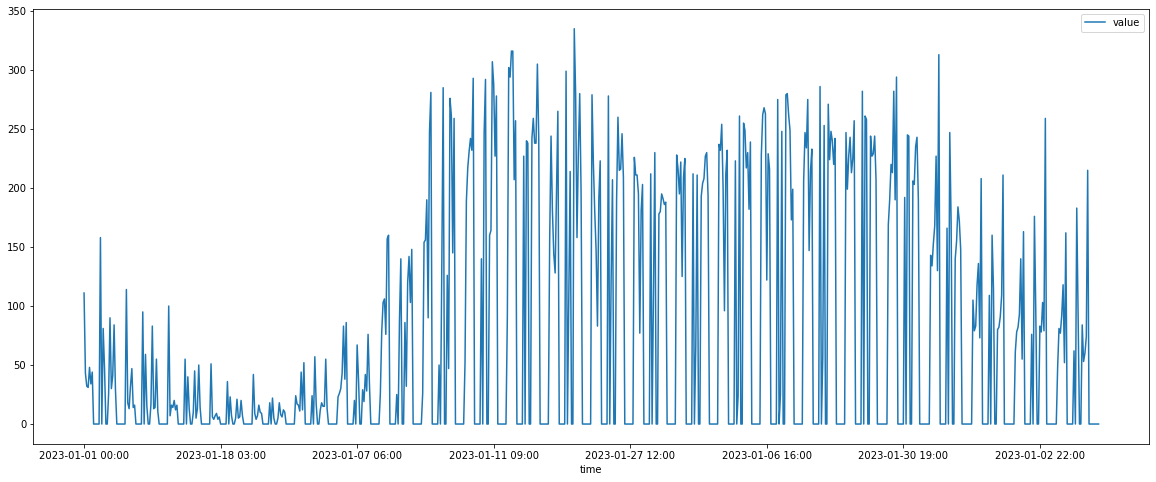

In [122]:
sdf[(sdf['year']== 2023) & (sdf['month']==1)].plot(figsize=(20,8),x='time',y="value")

<AxesSubplot:xlabel='time'>

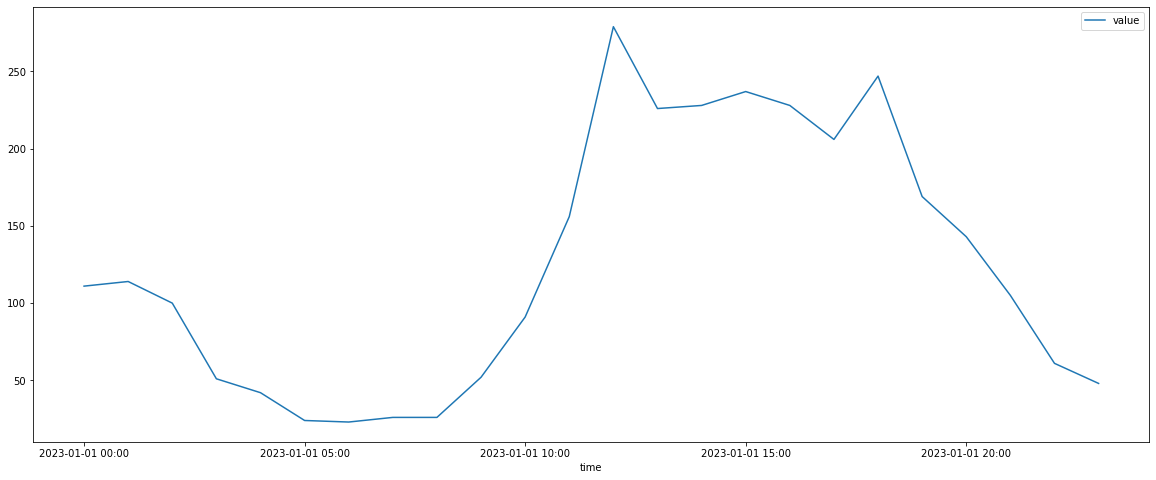

In [121]:
sdf[(sdf['year']== 2023) & (sdf['month']==1) & (sdf['day']==1)].plot(figsize=(20,8),x='time',y="value")

# Define function

In [ ]:
%%writefile "download-data.py"

import mlrun
import pandas as pd
import requests

URL = "https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/rilevazione-flusso-veicoli-tramite-spire-anno-2023/exports/csv?lang=it&timezone=Europe%2FRome&use_labels=true&delimiter=%3B"
filename = "rilevazione-flusso-veicoli-tramite-spire-anno-2023.csv"

@mlrun.handler(outputs=["dataset", "label_column"])
def data_downloader():
    with requests.get(URL) as r:
        with open(filename, "wb") as f:
            f.write(r.content)
        
    # call API and parse JSON as DF
    response = requests.get(URL).json()
    df = pd.json_normalize(response, record_path=['data'])
    # process data
    keys = ["prname","sname", "mvalidtime","mvalue","smetadata.capacity","scoordinate.y","scoordinate.x","smetadata.municipality","stype"]
    columns = ["id","name","time","value","capacity","lat","lon","municipality","type"]
    pdf = df[keys].dropna()
    pdf.set_axis(columns, axis=1, inplace=True)
    pdf.reset_index(inplace=True,drop=True)
    
    return pdf

In [7]:
download_data_fn = project.set_function("download-data.py", name="download-data", kind="job", image="mlrun/mlrun", handler="data_downloader")
project.save()  # save the project with the latest config

NameError: name 'project' is not defined

In [62]:
download_data_run = project.run_function("download-data", local=True)

> 2023-03-06 13:03:25,738 [info] starting run download-data-data_downloader uid=0ee0da628f5b432b83b0eccb375ab857 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
demo-jovyan,...375ab857,0,Mar 06 13:03:25,completed,download-data-data_downloader,kind=owner=jovyanhost=mlrun-jupyter-6b44556b98-nngf5,,,,dataset


> 2023-03-06 13:03:26,671 [info] run executed, status=completed


# Schedule and run on cluster

In [68]:
cron = "*/10 * * * *" #every 10 minutes

In [66]:
project.get_function("download-data")

In [69]:
download_data_fn.run(schedule=cron)

> 2023-03-06 13:05:56,110 [info] starting run download-data-data_downloader uid=f0d609d3c0854cefac9d17d00eec58f6 DB=http://mlrun-api:8080
> 2023-03-06 13:05:56,229 [info] task scheduled, {'schedule': '*/10 * * * *', 'project': 'demo-jovyan', 'name': 'download-data-data_downloader'}


# Read data

In [71]:
download_data_run.artifact("dataset")

's3://mlrun/projects/demo-jovyan/artifacts/download-data-data_downloader/0/dataset.parquet'

In [77]:
rdf = download_data_run.artifact("dataset").as_df()

In [78]:
rdf.head()

,id,name,time,value,capacity,lat,lon,municipality,type
0,odh-mobility-dc-parking-tn,Area ex SIT via Canestrini - P1,2022-07-17 19:00:25.913+0000,0,300.0,46.069100,11.116200,Trento,ParkingStation
1,odh-mobility-dc-parking-tn,Centro Europa - P2,2022-09-23 01:00:00.539+0000,293,480.0,46.073551,11.121393,Trento,ParkingStation
2,odh-mobility-dc-parking-tn,CTE via Bomporto - P6,2022-09-23 01:00:00.539+0000,250,250.0,46.065000,11.116300,Trento,ParkingStation
3,odh-mobility-dc-parking-tn,Duomo - P5,2022-09-23 01:00:00.539+0000,198,300.0,46.067219,11.115151,Trento,ParkingStation
4,odh-mobility-dc-parking-tn,Piazza Fiera - P4,2022-09-23 01:00:00.539+0000,198,450.0,46.065635,11.125044,Trento,ParkingStation


In [79]:
dataset = download_data_run.artifact("dataset").local()

> 2023-03-06 13:15:32,193 [info] downloading s3://mlrun/projects/demo-jovyan/artifacts/download-data-data_downloader/0/dataset.parquet to local temp file


In [80]:
dataset

'/tmp/tmpe2wgj2eu.parquet'

In [98]:
key = 'store://datasets/demo-jovyan/download-data-data_downloader_dataset'
#key = 'store://datasets/demo-jovyan/download-data-data_downloader_dataset#0:latest'
#key = 'store://datasets/demo-jovyan/download-data-data_downloader_dataset#0:latest'

In [99]:
di = mlrun.run.get_dataitem(key)

In [100]:
di.as_df()

,id,name,time,value,capacity,lat,lon,municipality,type
0,odh-mobility-dc-parking-tn,Area ex SIT via Canestrini - P1,2022-07-17 19:00:25.913+0000,0,300.0,46.069100,11.116200,Trento,ParkingStation
1,odh-mobility-dc-parking-tn,Centro Europa - P2,2022-09-23 01:00:00.539+0000,293,480.0,46.073551,11.121393,Trento,ParkingStation
2,odh-mobility-dc-parking-tn,CTE via Bomporto - P6,2022-09-23 01:00:00.539+0000,250,250.0,46.065000,11.116300,Trento,ParkingStation
3,odh-mobility-dc-parking-tn,Duomo - P5,2022-09-23 01:00:00.539+0000,198,300.0,46.067219,11.115151,Trento,ParkingStation
4,odh-mobility-dc-parking-tn,Piazza Fiera - P4,2022-09-23 01:00:00.539+0000,198,450.0,46.065635,11.125044,Trento,ParkingStation
5,odh-mobility-dc-parking-tn,Piazzale Sanseverino - P7,2022-09-23 01:00:00.539+0000,272,342.0,46.065700,11.114500,Trento,ParkingStation
6,odh-mobility-dc-parking-tn,Autosilo Buonconsiglio - P3,2022-09-23 01:00:00.539+0000,633,633.0,46.073612,11.124208,Trento,ParkingStation
7,odh-mobility-dc-parking-tn,A.S.M.,2023-01-17 02:00:00.208+0000,59,145.0,45.893593,11.036507,Rovereto,ParkingStation
8,odh-mobility-dc-parking-tn,Centro Storico,2023-01-17 02:00:00.208+0000,123,143.0,45.890306,11.045004,Rovereto,ParkingStation
9,odh-mobility-dc-parking-tn,Mart,2023-01-17 02:00:00.208+0000,0,224.0,45.894705,11.044661,Rovereto,ParkingStation


In [166]:
BZ_SHAPE_URL='https://www.catastobz.it/download/cge/scarico/shp/dc_BZ/cc613_shp.zip'
MERAN_SHAPE_URL='https://www.catastobz.it/download/cge/scarico/shp/dc_MR/cc704_shp.zip'

In [105]:
import requests, zipfile, io

In [106]:
r = requests.get(BZ_SHAPE_URL)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/shapes/bozen")

In [201]:
%%writefile "download-shapefile.py"

import mlrun
import pandas as pd
import requests, zipfile, io

BZ_SHAPE_URL='https://www.catastobz.it/download/cge/scarico/shp/dc_BZ/cc613_shp.zip'
MR_SHAPE_URL='https://www.catastobz.it/download/cge/scarico/shp/dc_MR/cc704_shp.zip'

@mlrun.handler(outputs=["shapefile-bozen:file", "shapefile-meran:file"])
def data_downloader():
    res_bz = requests.get(BZ_SHAPE_URL)
    zf_bz = zipfile.ZipFile(io.BytesIO(res_bz.content))
    zf_bz.extractall("data/bozen")
    shp_bozen = "data/bozen.zip"
    with zipfile.ZipFile(shp_bozen, "w") as zf:
        zf.write("data/bozen/CC613_vl_boundary.shp","CC613_vl_boundary.shp")
        zf.write("data/bozen/CC613_vl_boundary.shx","CC613_vl_boundary.shx")
        zf.write("data/bozen/CC613_vl_boundary.prj","CC613_vl_boundary.prj")
        zf.write("data/bozen/CC613_vl_boundary.dbf","CC613_vl_boundary.dbf")

    res_mr = requests.get(MR_SHAPE_URL)
    zf_mr = zipfile.ZipFile(io.BytesIO(res_mr.content))
    zf_mr.extractall("data/meran")
    shp_meran = "data/meran.zip"
    with zipfile.ZipFile(shp_meran, "w") as zf:
        zf.write("data/meran/CC704_vl_boundary.shp","CC704_vl_boundary.shp")
        zf.write("data/meran/CC704_vl_boundary.shx","CC704_vl_boundary.shx")
        zf.write("data/meran/CC704_vl_boundary.prj","CC704_vl_boundary.prj")
        zf.write("data/meran/CC704_vl_boundary.dbf","CC704_vl_boundary.dbf")
    
    return shp_bozen,shp_meran


Overwriting download-shapefile.py


In [202]:
download_shapefile_fn = project.set_function("download-shapefile.py", name="download-shapefile", kind="job", image="mlrun/mlrun", handler="data_downloader")
project.save()  # save the project with the latest config

In [203]:
download_shapefile_run = project.run_function("download-shapefile", local=True)

> 2023-03-06 15:02:28,355 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-03-06 15:02:28,366 [info] starting run download-shapefile-data_downloader uid=5e39ca2fdada4770bf31761c61f337a5 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
demo-jovyan,...61f337a5,0,Mar 06 15:02:28,completed,download-shapefile-data_downloader,kind=owner=jovyanhost=mlrun-jupyter-6b44556b98-nngf5,,,,shapefile-bozenshapefile-meran


> 2023-03-06 15:02:29,367 [info] run executed, status=completed


In [253]:
download_shapefile_run.artifact("shapefile-bozen")

's3://mlrun/projects/demo-jovyan/artifacts/download-shapefile-data_downloader/0/shapefile-bozen.zip'

# Plot analysis

In [113]:
%pip install geopandas contextily


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [237]:
import geopandas as gpd
import contextily as cx
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [205]:
bz_di = mlrun.run.get_dataitem('store://artifacts/demo-jovyan/download-shapefile-data_downloader_shapefile-bozen#0:latest')
bz_shp_file = bz_di.local()

> 2023-03-06 15:02:36,881 [info] downloading s3://mlrun/projects/demo-jovyan/artifacts/download-shapefile-data_downloader/0/shapefile-bozen.zip to local temp file


In [206]:
bz_shp_file

'/tmp/tmp75lfaafw.zip'

In [207]:
bz_map = gpd.read_file("zip://"+bz_shp_file)

In [208]:
bz_map.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [209]:
bzmap = bz_map.to_crs(epsg=3857)

<AxesSubplot:>

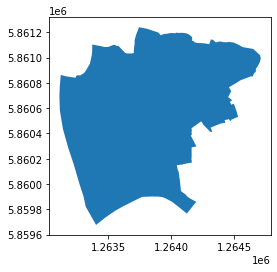

In [210]:
bzmap.plot()

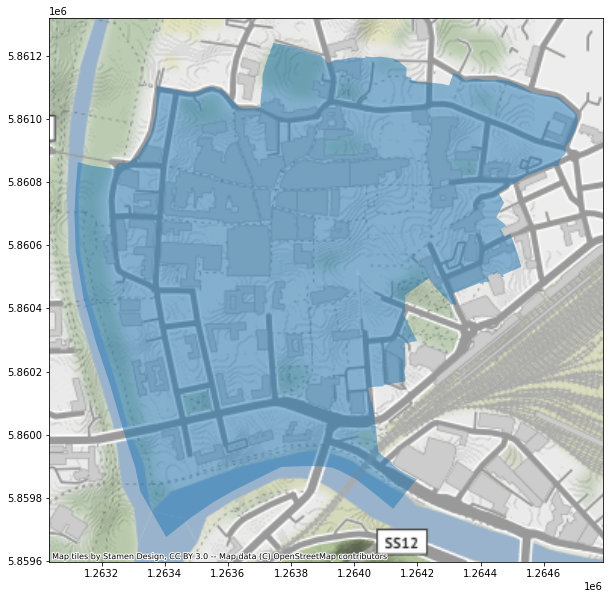

In [211]:
ax = bzmap.plot(figsize=(10, 10),alpha=0.5)
cx.add_basemap(ax,zoom=15, crs=bzmap.crs.to_string())

In [212]:
gdf = gpd.GeoDataFrame(rdf,crs={'init': 'epsg:4326'}, geometry=gpd.points_from_xy(rdf.lon, rdf.lat))

In [213]:
gdf.head()

,id,name,time,value,capacity,lat,lon,municipality,type,geometry
0,odh-mobility-dc-parking-tn,Area ex SIT via Canestrini - P1,2022-07-17 19:00:25.913+0000,0,300.0,46.069100,11.116200,Trento,ParkingStation,POINT (11.11620 46.06910)
1,odh-mobility-dc-parking-tn,Centro Europa - P2,2022-09-23 01:00:00.539+0000,293,480.0,46.073551,11.121393,Trento,ParkingStation,POINT (11.12139 46.07355)
2,odh-mobility-dc-parking-tn,CTE via Bomporto - P6,2022-09-23 01:00:00.539+0000,250,250.0,46.065000,11.116300,Trento,ParkingStation,POINT (11.11630 46.06500)
3,odh-mobility-dc-parking-tn,Duomo - P5,2022-09-23 01:00:00.539+0000,198,300.0,46.067219,11.115151,Trento,ParkingStation,POINT (11.11515 46.06722)
4,odh-mobility-dc-parking-tn,Piazza Fiera - P4,2022-09-23 01:00:00.539+0000,198,450.0,46.065635,11.125044,Trento,ParkingStation,POINT (11.12504 46.06564)


In [216]:
# derive status field
def evaluate_status(d):
    if(d["value"] == 0):
        return "empty"
    if((d["capacity"] - d["value"]) >= 10):
        return 'free'
    if((d["capacity"] - d["value"]) < 10 and (d["capacity"] - d["value"]) > 1):
        return 'almost-full'
    return "full"
    

In [234]:
gdf["status"]=gdf.apply(evaluate_status,axis=1)
gdf["free"] = gdf["capacity"] - gdf["value"]

In [231]:
gdf_motif = gdf[gdf["municipality"] == 'Bolzano - Bozen'].to_crs(epsg=3857)

In [235]:
gdf_motif

,id,name,time,value,capacity,lat,lon,municipality,type,geometry,status,free
12,odh-mobility-dc-parking-offstreet-meranobolzano,P03 - Piazza Walther,2023-03-06 13:04:28.000+0000,293,403.0,46.497805,11.355115,Bolzano - Bozen,ParkingStation,POINT (1264045.620 5860484.866),free,110.0
13,odh-mobility-dc-parking-offstreet-meranobolzano,P04 - Luna via Molini,2023-03-06 13:04:28.000+0000,80,150.0,46.500551,11.358216,Bolzano - Bozen,ParkingStation,POINT (1264390.821 5860928.937),free,70.0
14,dc-parking-MeBo,P05 - Laurin,2021-12-26 07:05:03.000+0000,33,90.0,46.498174,11.357255,Bolzano - Bozen,ParkingStation,POINT (1264283.843 5860544.537),free,57.0
15,odh-mobility-dc-parking-offstreet-meranobolzano,P08 - BZ Centro via Mayr Nusser,2023-03-06 13:04:28.000+0000,457,1055.0,46.494402,11.356716,Bolzano - Bozen,ParkingStation,POINT (1264223.842 5859934.578),free,598.0
16,odh-mobility-dc-parking-offstreet-meranobolzano,P15 - Palasport via Resia,2023-03-06 13:04:28.000+0000,209,425.0,46.491603,11.318078,Bolzano - Bozen,ParkingStation,POINT (1259922.680 5859481.987),free,216.0
17,odh-mobility-dc-parking-offstreet-meranobolzano,P16 - Fiera via Marco Polo/Buozzi,2023-03-06 13:05:04.000+0000,192,770.0,46.472249,11.327066,Bolzano - Bozen,ParkingStation,POINT (1260923.219 5856353.132),free,578.0
23,odh-mobility-dc-parking-offstreet-meranobolzano,P06 - Central Parking via Renon,2022-10-26 18:30:04.000+0000,144,459.0,46.497134,11.358907,Bolzano - Bozen,ParkingStation,POINT (1264467.743 5860376.358),free,315.0


In [238]:
palette = {'empty': 'blu', 'free':'green','almost-full':'orange','full':'red'}
cmap = matplotlib.colors.ListedColormap([palette[c] for c in gdf_motif.status.unique()])


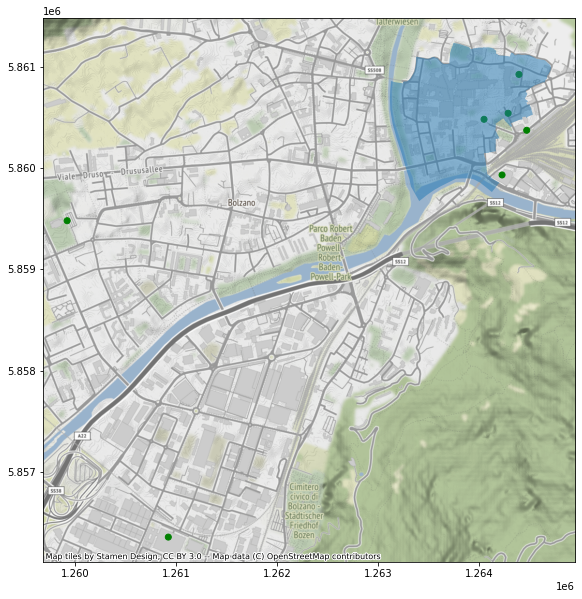

In [241]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_motif.plot(ax=ax, alpha=1, column='status', cmap=cmap)
bzmap.plot(ax=ax,alpha=0.5)
cx.add_basemap(ax,zoom=15, crs=bzmap.crs.to_string())

# plot function

In [248]:
%%writefile "plot-data.py"

import mlrun
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

BZ_SHAPE_URL='store://artifacts/demo-jovyan/download-shapefile-data_downloader_shapefile-bozen#0:latest'
DF_URL='store://datasets/demo-jovyan/download-data-data_downloader_dataset#0:latest'

# derive status field
def evaluate_status(d):
    if(d["value"] == 0):
        return "empty"
    if((d["capacity"] - d["value"]) >= 10):
        return 'free'
    if((d["capacity"] - d["value"]) < 10 and (d["capacity"] - d["value"]) > 1):
        return 'almost-full'
    return "full"

@mlrun.handler(outputs=["map:file"])
def plot_data(context, dfi: mlrun.DataItem, shpi: mlrun.DataItem):
    # read data as df
    rdf = dfi.as_df()
    gdf = gpd.GeoDataFrame(rdf,crs={'init': 'epsg:4326'}, geometry=gpd.points_from_xy(rdf.lon, rdf.lat))
    gdf["status"]=gdf.apply(evaluate_status,axis=1)
    gdf["free"] = gdf["capacity"] - gdf["value"]

    # read shapefile by local copy
    shp_file = shpi.local()
    shp = gpd.read_file("zip://"+shp_file)
    
    #process geo
    bzmap = shp.to_crs(epsg=3857)
    gdf_motif = gdf[gdf["municipality"] == 'Bolzano - Bozen'].to_crs(epsg=3857)
    
    #plot
    mapfile ='map.png'
    palette = {'empty': 'blu', 'free':'green','almost-full':'orange','full':'red'}
    cmap = matplotlib.colors.ListedColormap([palette[c] for c in gdf_motif.status.unique()])
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_motif.plot(ax=ax, alpha=1, column='status', cmap=cmap)
    bzmap.plot(ax=ax,alpha=0.5)
    cx.add_basemap(ax,zoom=15, crs=bzmap.crs.to_string())
    fig.savefig(mapfile)
    
    return mapfile

Overwriting plot-data.py


In [267]:
plot_data_fn = project.set_function("plot-data.py", name="plot-data", kind="job", image="mlrun/mlrun", handler="plot_data",requirements=["geopandas", "contextily"])
project.save()  # save the project with the latest config

> 2023-03-06 15:36:49,640 [info] starting run plot-data-plot_data uid=305c40fa6bcd423c8be783519bec4b88 DB=http://mlrun-api:8080
> 2023-03-06 15:36:50,252 [info] downloading s3://mlrun/projects/demo-jovyan/artifacts/download-shapefile-data_downloader/0/shapefile-bozen.zip to local temp file


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
demo-jovyan,...9bec4b88,0,Mar 06 15:36:49,completed,plot-data-plot_data,kind=owner=jovyanhost=mlrun-jupyter-6b44556b98-nngf5,dfishpi,,,map


> 2023-03-06 15:36:52,241 [info] run executed, status=completed


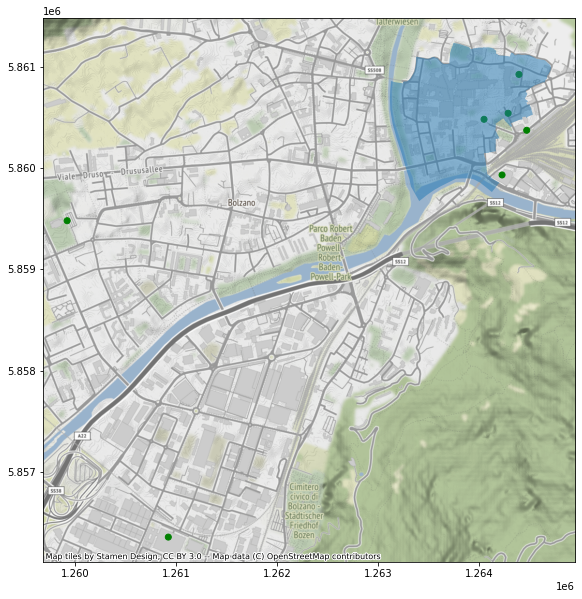

In [251]:
BZ_SHAPE_URL='store://artifacts/demo-jovyan/download-shapefile-data_downloader_shapefile-bozen#0:latest'
DF_URL='store://datasets/demo-jovyan/download-data-data_downloader_dataset#0:latest'

plot_data_run = project.run_function("plot-data",inputs={'dfi': DF_URL, 'shpi':BZ_SHAPE_URL}, local=True)

In [269]:
project.build_function("plot-data", base_image="mlrun/mlrun")

> 2023-03-06 16:04:24,049 [info] Started building image: .mtsl/func-demo-jovyan-plot-data:latest
INFO[0001] Retrieving image manifest mlrun/mlrun:1.2.1  
INFO[0001] Retrieving image mlrun/mlrun:1.2.1 from registry index.docker.io 
INFO[0002] Built cross stage deps: map[]                
INFO[0002] Retrieving image manifest mlrun/mlrun:1.2.1  
INFO[0002] Returning cached image manifest              
INFO[0002] Executing 0 build triggers                   
INFO[0002] Unpacking rootfs as cmd RUN python -m pip install geopandas contextily requires it. 
INFO[0054] RUN python -m pip install geopandas contextily 
INFO[0054] Taking snapshot of full filesystem...        
INFO[0063] cmd: /bin/sh                                 
INFO[0063] args: [-c python -m pip install geopandas contextily] 
INFO[0063] Running: [/bin/sh -c python -m pip install geopandas contextily] 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6

BuildStatus(ready=True, outputs={'image': '.mtsl/func-demo-jovyan-plot-data:latest'})

In [270]:
plot_data_run = project.run_function("plot-data",inputs={'dfi': 'store://artifacts/demo-jovyan/download-data_dataset:865391f7-28e4-4194-85d8-e806ca0ca544', 'shpi': 's3://mlrun/projects/demo-jovyan/artifacts/865391f7-28e4-4194-85d8-e806ca0ca544/download-shapefile/0/shapefile-bozen.zip'})


> 2023-03-06 16:06:59,345 [info] starting run plot-data-plot_data uid=802b2f2bbe204135b10060c4532576c7 DB=http://mlrun-api:8080
> 2023-03-06 16:06:59,465 [info] Job is running in the background, pod: plot-data-plot-data-qbc5c
> 2023-03-06 16:07:41,290 [info] downloading s3://mlrun/projects/demo-jovyan/artifacts/865391f7-28e4-4194-85d8-e806ca0ca544/download-shapefile/0/shapefile-bozen.zip to local temp file
> 2023-03-06 16:07:47,561 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 802b2f2bbe204135b10060c4532576c7 -p demo-jovyan', 'logs_cmd': 'mlrun logs 802b2f2bbe204135b10060c4532576c7 -p demo-jovyan'}
> 2023-03-06 16:07:47,562 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
demo-jovyan,...532576c7,0,Mar 06 16:07:39,completed,plot-data-plot_data,kind=jobowner=jovyanmlrun/client_version=1.2.1host=plot-data-plot-data-qbc5c,dfishpi,,,map


> 2023-03-06 16:07:50,528 [info] run executed, status=completed


# Pipeline

define a pipeline with steps:

* download data from API
* store df
* download + store shapefiles
* download df + shapefile and output plot

In [262]:
%%writefile "pipeline.py"

from kfp import dsl
import mlrun

funcs = {}

in_kfp = True


@dsl.pipeline(name="Demo pipeline", description="Mock up pipeline for parkings")
def data_pipeline():
    project = mlrun.get_current_project()

    # run API downloader
    downloader = project.run_function("download-data",outputs=["dataset"])

    # run SHAPEFILE downloader (in parallel)
    shapes = project.run_function("download-shapefile",outputs=["shapefile-bozen"])

    # plot
    plot_data_run = project.run_function("plot-data",inputs={'dfi': downloader.outputs["dataset"], 'shpi':shapes.outputs["shapefile-bozen"]})
  

Overwriting pipeline.py


In [263]:
# register the workflow in the project and save the project
project.set_workflow("main", "pipeline.py", handler="data_pipeline")
project.save()

In [264]:
project.run("main")

> 2023-03-06 15:57:42,216 [info] submitted pipeline demo-jovyan-main 2023-03-06 15-57-42 id=865391f7-28e4-4194-85d8-e806ca0ca544
> 2023-03-06 15:57:42,217 [info] Pipeline run id=865391f7-28e4-4194-85d8-e806ca0ca544, check UI for progress


> 2023-03-06 15:57:42,345 [info] started run workflow demo-jovyan-main with run id = '865391f7-28e4-4194-85d8-e806ca0ca544' by kfp engine


865391f7-28e4-4194-85d8-e806ca0ca544

# Populate API

In [275]:
DF_URL='store://datasets/demo-jovyan/download-data-data_downloader_dataset#0:latest'

In [277]:
rdf = download_data_run.artifact("dataset").as_df()

In [279]:
rdf.head()

,id,name,time,value,capacity,lat,lon,municipality,type
0,odh-mobility-dc-parking-tn,Area ex SIT via Canestrini - P1,2022-07-17 19:00:25.913+0000,0,300.0,46.069100,11.116200,Trento,ParkingStation
1,odh-mobility-dc-parking-tn,Centro Europa - P2,2022-09-23 01:00:00.539+0000,293,480.0,46.073551,11.121393,Trento,ParkingStation
2,odh-mobility-dc-parking-tn,CTE via Bomporto - P6,2022-09-23 01:00:00.539+0000,250,250.0,46.065000,11.116300,Trento,ParkingStation
3,odh-mobility-dc-parking-tn,Duomo - P5,2022-09-23 01:00:00.539+0000,198,300.0,46.067219,11.115151,Trento,ParkingStation
4,odh-mobility-dc-parking-tn,Piazza Fiera - P4,2022-09-23 01:00:00.539+0000,198,450.0,46.065635,11.125044,Trento,ParkingStation


In [282]:
rdf.to_json(orient='records')

'[{"id":"odh-mobility-dc-parking-tn","name":"Area ex SIT via Canestrini - P1","time":"2022-07-17 19:00:25.913+0000","value":0,"capacity":300.0,"lat":46.0691,"lon":11.1162,"municipality":"Trento","type":"ParkingStation"},{"id":"odh-mobility-dc-parking-tn","name":"Centro Europa - P2","time":"2022-09-23 01:00:00.539+0000","value":293,"capacity":480.0,"lat":46.073551,"lon":11.121393,"municipality":"Trento","type":"ParkingStation"},{"id":"odh-mobility-dc-parking-tn","name":"CTE via Bomporto - P6","time":"2022-09-23 01:00:00.539+0000","value":250,"capacity":250.0,"lat":46.065,"lon":11.1163,"municipality":"Trento","type":"ParkingStation"},{"id":"odh-mobility-dc-parking-tn","name":"Duomo - P5","time":"2022-09-23 01:00:00.539+0000","value":198,"capacity":300.0,"lat":46.067219,"lon":11.115151,"municipality":"Trento","type":"ParkingStation"},{"id":"odh-mobility-dc-parking-tn","name":"Piazza Fiera - P4","time":"2022-09-23 01:00:00.539+0000","value":198,"capacity":450.0,"lat":46.065635,"lon":11.125

In [285]:
%%writefile "api.py"

import mlrun
import pandas as pd

DF_URL='store://datasets/demo-jovyan/download-data-data_downloader_dataset#0:latest'
df = None

def init_context(context):
    global df
    di = mlrun.run.get_dataitem(DF_URL)
    df = di.as_df()
    
def handler(context, event):
    global df
    if df is None:
        return context.Response(body='',
                                headers={},
                                content_type='application/json',
                                status_code=500)    
    json = df.to_json(orient='records')
    return context.Response(body=json,
                                headers={},
                                content_type='application/json',
                                status_code=200)  


Overwriting api.py


In [286]:
api_fn = project.set_function("api.py", name="api", kind="nuclio", image="mlrun/mlrun", handler="handler")
project.save()  # save the project with the latest config

In [291]:
api_fn.deploy()

> 2023-03-07 12:49:52,510 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-03-07 12:49:52,514 [info] Starting remote function deploy
2023-03-07 12:49:52  (info) Deploying function
2023-03-07 12:49:52  (info) Building
2023-03-07 12:49:52  (info) Staging files and preparing base images
2023-03-07 12:49:52  (info) Building processor image
2023-03-07 12:52:17  (info) Build complete
> 2023-03-07 12:52:31,770 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-demo-jovyan-api.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['192.168.49.2:32048']}


'http://192.168.49.2:32048'

In [292]:
api_fn.invoke("")

> 2023-03-07 12:53:55,332 [info] invoking function: {'method': 'GET', 'path': 'http://nuclio-demo-jovyan-api.mlrun.svc.cluster.local:8080/'}


[{'id': 'odh-mobility-dc-parking-tn',
  'name': 'Area ex SIT via Canestrini - P1',
  'time': '2022-07-17 19:00:25.913+0000',
  'value': 0,
  'capacity': 300.0,
  'lat': 46.0691,
  'lon': 11.1162,
  'municipality': 'Trento',
  'type': 'ParkingStation'},
 {'id': 'odh-mobility-dc-parking-tn',
  'name': 'Centro Europa - P2',
  'time': '2022-09-23 01:00:00.539+0000',
  'value': 293,
  'capacity': 480.0,
  'lat': 46.073551,
  'lon': 11.121393,
  'municipality': 'Trento',
  'type': 'ParkingStation'},
 {'id': 'odh-mobility-dc-parking-tn',
  'name': 'CTE via Bomporto - P6',
  'time': '2022-09-23 01:00:00.539+0000',
  'value': 250,
  'capacity': 250.0,
  'lat': 46.065,
  'lon': 11.1163,
  'municipality': 'Trento',
  'type': 'ParkingStation'},
 {'id': 'odh-mobility-dc-parking-tn',
  'name': 'Duomo - P5',
  'time': '2022-09-23 01:00:00.539+0000',
  'value': 198,
  'capacity': 300.0,
  'lat': 46.067219,
  'lon': 11.115151,
  'municipality': 'Trento',
  'type': 'ParkingStation'},
 {'id': 'odh-mobili